In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns

In [3]:
import os
import sys

In [4]:
# chaging directory

In [5]:
root, *_ = !pwd

In [6]:
if root.endswith('notebooks'):
    os.chdir('../')
    root, *_ = !pwd
    sys.path.append('src/')

In [7]:
os.getcwd()

'/home/med/projects/competitions/mlb-kaggle'

In [8]:
from dotenv import load_dotenv
load_dotenv()

True

In [9]:
RAW_PATH = Path(os.environ['RAW_PATH'])

In [10]:
os.listdir(RAW_PATH)

['seasons.csv',
 'teams.csv',
 'example_sample_submission.csv',
 'train.csv',
 'mlb-player-digital-engagement-forecasting.zip',
 'awards.csv',
 'players.csv',
 'example_test.csv',
 'mlb']

In [ ]:
train_data = pd.read_csv(RAW_PATH / 'train.csv', parse_dates=['date'])
train_data = train_data.set_index('date')

In [ ]:
train_data.head()

### time and player data 

In [ ]:
from pipeline import *

In [ ]:
_players = pd.read_csv(RAW_PATH / 'players.csv')

In [ ]:
_players['playerForTestSetAndFuturePreds'].fillna(False, inplace=True)

In [ ]:
player_in_test = _players.query('playerForTestSetAndFuturePreds')['playerId']

### target 

In [ ]:
from command.ingest_data import *

In [ ]:
from data.util import *

In [ ]:
%time target = ingest_target(train_data)

In [ ]:
target.head()

In [ ]:
df = target.copy()

In [ ]:
df = filter_by_id(df, player_in_test)

In [ ]:
playerList = df.groupby(['playerId'])['target_avg'].std().sort_values(ascending=False).reset_index()

In [ ]:
playerList

In [ ]:
df = filter_by_id(df, playerList['playerId'].head(5))

In [ ]:
df.playerId.nunique()

In [ ]:
# player stats

In [ ]:
train_data.columns

In [ ]:
df = ingest_player_stats(df, train_data)

In [ ]:
# del train_data

### preprocessing 

In [ ]:
# from pipeline.stats import *
# from pipeline.categories import *
# from pipeline.continuous import *
# from pipeline.core import *

In [ ]:
def gen_hardcoded_features(df: pd.DataFrame):
    # some feature eng for the dates
    df['playerAge'] = (df['date'] - df['DOB']).dt.total_seconds()
    df['playerTSinceDebut'] = (df['date'] - df['mlbDebutDate']).dt.total_seconds()
    df['playerDebutAge'] = (df['mlbDebutDate'] - df['DOB']).dt.total_seconds()
    # normalize
    df[['playerAge', 'playerTSinceDebut', 'playerDebutAge']] /= 60 * 60 * 24 * 365
    
    return df

In [ ]:
def fillna(df: pd.DataFrame, fill_value=-1):
    return df.fillna(-1)

In [ ]:
# transformer for joining data and create base features

join_season_tmf = FunctionTransformer(join_season_info,
                                      kw_args={'path_to_season': RAW_PATH / 'seasons.csv',
                                             'date_attr': ['year', 'month']})
join_players_tmf = FunctionTransformer(join_players_info, kw_args={'path_to_players': RAW_PATH / 'players.csv'})
harcoded_feat_tmf = FunctionTransformer(gen_hardcoded_features)

In [ ]:
# creating pipeline
join_and_compute_feat_pl = Pipeline([('season', join_season_tmf),
                                     ('players', join_players_tmf),
                                     ('hardcoded_feat', harcoded_feat_tmf)])

In [ ]:
# features to use for target preprocessing
target_cols = ['target1', 'target2', 'target3', 'target4']
index_cols = ['date', 'playerId']
pp_cols = target_cols + index_cols

In [ ]:
# categories encoding
categories = ['playerId', 'seasonPart', 'year',
              'primaryPositionName', 'month']
categories_tmf = PdColumnTransformer([(category, Categorify(add_nan=True), category)
                                       for category in categories])

In [ ]:
# target statistics

stats_gen_tmf = StatisticGen(stats=['mean', 'median', 'std'], windows=[90], drop_index=True)
stats_lagger_tmf = LagGen(lags=[1], drop_index=False)

# create mean and median stats after lagging the target 1 day
stats_lagger_tmf = Pipeline([('lags', stats_lagger_tmf),
                             ('stats', stats_gen_tmf),
                             ('fillnan', FunctionTransformer(fillna)),
                             ('normalize', PdScaleNorm())])

# last 11 days as features
lagger_tmf = Pipeline([('lags', LagGen(lags=[1])),
                       ('fillnan', FunctionTransformer(fillna)),
                       ('normalize', PdScaleNorm())])


target_stats_tmf = PdColumnTransformer([
    ('lags_stats', stats_lagger_tmf, pp_cols),
#                                         ('lags', lagger_tmf, pp_cols)
                                  ])

In [ ]:
# %%time
# target_stats_tmf.fit_transform(df)

In [ ]:
# %%time
# target_stats_tmf.fit_transform(df)

In [ ]:
# continuous preprocessing


# get the rest of the continuous features
continuous_feat_tmf = Pipeline([('get_cont_feat', FilterContinuousFeatures()),
                                ('fillnan', FunctionTransformer(fillna)),
                                ('normalize', PdScaleNorm())])

In [ ]:
# putting all together
all_features_tmf = PdFeatureUnion([('target_stats', target_stats_tmf), 
                                   ('cont_feat', continuous_feat_tmf), 
                                  ('cats', categories_tmf)
                                  ])

In [ ]:
# main pipeline with all steps 
pipeline = Pipeline([('join_compute', join_and_compute_feat_pl),
                    ('features_gen', all_features_tmf)])

In [ ]:
pipeline

In [ ]:
from data.split import *

In [ ]:
sp = SplitData("2021-04-01")

In [ ]:
train_idx = sp.train_idx(df)
valid_idx = sp.valid_idx(df)

In [ ]:
%%time
pipeline.fit(sp.filter(df, train_idx))

In [ ]:
%%time
features = pipeline.transform(df)

In [ ]:
pd.options.display.max_rows = 100
features.T

In [ ]:
continuous_feat = features.columns.drop(categories)

In [ ]:
df[target_cols] = df[target_cols].astype(np.float32)

In [ ]:
train_data = sp.filter(features, train_idx)
raw_train_df = sp.filter(df, train_idx)

In [ ]:
valid_data = sp.filter(features, valid_idx)
raw_valid_df = sp.filter(df, valid_idx)

In [ ]:
train_data.shape, raw_valid_df.shape

In [ ]:
valid_data.shape, raw_train_df.shape

In [ ]:
train_data[target_cols + ['date']] = raw_train_df[target_cols + ['date']]
valid_data[target_cols + ['date']] = raw_valid_df[target_cols + ['date']]

### modeling 

In [ ]:
from torch.utils.data import DataLoader
import torch
from typing import Dict


class PlayerDataset:
    def __init__(self, features: np.ndarray,
                 categories: np.ndarray,
                 target: np.ndarray = None,
                 lag: int = 10,
                 device: torch.device = torch.device('cpu')):
        self.features = features
        self.target = target
        self.lag = lag - 1
        self.device = device
        self.categories = categories
        assert len(self) > self.lag, f'lenght: {len(self)}, lags: {self.lag}'
        
    def __len__(self):
        return len(self.features)
    
    def _to_torch(self, array):
        return torch.from_numpy(np.asarray(array)).to(device=self.device)
    
    def to_device(self, batch_item: Dict[str, np.ndarray]):
        return {name: self._to_torch(values)
                for name, values in batch_item.items()}
    
    def __getitem__(self, idx: int):
        
        start_idx = max(0, idx - self.lag)
        timeft = self.features[start_idx: idx + 1]
        
        if len(timeft) <= self.lag:
            missing_steps = self.lag - len(timeft) + 1
            timeft = np.pad(timeft, pad_width=((missing_steps, 0), (0, 0)))        
        cats = self.categories[idx]
        
        batch_item = {"features": timeft, 'categories': cats}
        if self.target is not None:
            batch_item['target'] = self.target[idx]
    
        return self.to_device(batch_item)

    
class MultiPlayerDataset:
    def __init__(self, ds: List[PlayerDataset]):
        self.ds = ds
        self.cum_lenght = np.cumsum([0] + list(map(len, self.ds)))
        
    def __len__(self):
        return self.cum_lenght[-1]
    
    def __getitem__(self, idx):
        ds_idx = np.argmax(self.cum_lenght > idx) - 1
        ds = self.ds[ds_idx]        
        right_idx = idx - self.cum_lenght[ds_idx]
        return ds[idx - self.cum_lenght[ds_idx]]

    @classmethod
    def from_df(cls, df: pd.DataFrame,
                playerIds,
                features: List[str],
                categories: List[str],
                target: List[str]=None,
                lag: int = 30,
                device: torch.device = torch.device('cpu')):
#         df.sort_values(by=['playerId', 'date'], inplace=True)
        df.reset_index(drop=True, inplace=True)
        
        ds = []
        for playerId, pdf in df.groupby(playerIds):
            pl_target = (pdf.loc[:, target].to_numpy() if target is not None else None)
            pds = PlayerDataset(pdf.loc[:, features].to_numpy(),
                                pdf.loc[:, categories].to_numpy(),
                                target=pl_target,
                                lag=lag,
                               device=device)
            ds.append(pds)
        
        return cls(ds)

In [ ]:
from torch import nn, optim
from torch.nn import functional as F

In [ ]:
def mae(yhat, y):
    return torch.abs(yhat-y).mean()

In [ ]:
from typing import List, Tuple

class EmbeddingLayer(nn.Module):
    def __init__(self, emb_szs: List[Tuple[int, int]], dropout: float = 0.):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.emb = nn.ModuleList([nn.Embedding(size, hidden_dim)
                              for (size, hidden_dim) in emb_szs])
        
        self.out_features = sum([hidden_dim for (_, hidden_dim) in emb_szs])
    
    def forward(self, x):
        output = torch.cat([emb(x[:, e]) for e, emb in enumerate(self.emb)], dim=1)
        output = self.dropout(output)
        return output

In [ ]:
import pytorch_lightning as pl

In [ ]:
class LstmModel(pl.LightningModule):
    def __init__(self, in_features: int,
                 emb_szs,
                 hidden_dim: int,
                 out_features: int = 1,
                 n_layers: int = 2):
        super().__init__()
        self.emb = EmbeddingLayer(emb_szs, dropout=0.05)
        self.hidden_dim = hidden_dim
        self.net = nn.LSTM(in_features, hidden_dim, batch_first=True)
        # decoder
        self.output_layer = nn.Sequential(nn.Linear(hidden_dim + self.emb.out_features, hidden_dim),
                                          nn.ReLU(),
                                          nn.BatchNorm1d(hidden_dim),
                                          nn.Dropout(0.05),
                                          nn.Linear(hidden_dim, out_features))
        self.loss = mae
        
    def _init_hidden(self, bs):
        return next(self.parameters()).new(1, bs, self.hidden_dim).zero_()
        
    def init_hidden_state(self, bs):
        return (self._init_hidden(bs), self._init_hidden(bs))
    
    def forward(self, features,
                categories,
                target=None):        
        bs, sq, ft = features.size()
        hidden_state = self.init_hidden_state(bs)
        
        _, (final_state, _) = self.net(features, hidden_state)
        
        final_state.squeeze_(dim=0)
        categories = self.emb(categories)
        final_state = torch.cat((categories, final_state), dim=1)
        prediction = self.output_layer(final_state)
        # scaled prediction to 0 to 100
        prediction = torch.sigmoid(prediction) * 100

        return prediction
    
    def training_step(self, batch, batch_idx):
        y_hat = self(**batch)
        loss = mae(y_hat, batch['target'])
        self.log('train_mae', loss, on_epoch=True,
                 prog_bar=True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx):
        y_hat = self(**batch)
        loss = mae(y_hat, batch['target'])
        self.log('valid_mae', loss, on_epoch=True,
                 prog_bar=True, sync_dist=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.01)
        return optimizer

In [ ]:
# class GRUModel(pl.LightningModule):
#     def __init__(self, in_features: int,
#                  emb_szs,
#                  hidden_dim: int,
#                  out_features: int = 1,
#                  n_layers: int = 2):
#         super().__init__()
#         self.emb = EmbeddingLayer(emb_szs, dropout=0.05)
#         self.hidden_dim = hidden_dim
#         self.net = nn.GRU(in_features, hidden_dim, batch_first=True)
#         # decoder
#         self.output_layer = nn.Sequential(nn.Linear(hidden_dim + self.emb.out_features, hidden_dim),
#                                           nn.ReLU(),
#                                           nn.BatchNorm1d(hidden_dim),
#                                           nn.Dropout(0.05),
#                                           nn.Linear(hidden_dim, out_features))
        
#     def _init_hidden(self, bs):
#         return next(self.parameters()).new(1, bs, self.hidden_dim).zero_()
        
#     def init_hidden_state(self, bs):
#         return self._init_hidden(bs)
    
#     def forward(self, features,
#                 categories,
#                 target=None):        
#         bs, sq, ft = features.size()
#         hidden_state = self.init_hidden_state(bs)
        
#         _, final_state = self.net(features, hidden_state)
        
#         final_state.squeeze_(dim=0)
#         categories = self.emb(categories)
#         final_state = torch.cat((categories, final_state), dim=1)
#         prediction = self.output_layer(final_state)
#         # scaled prediction to 0 to 100
#         prediction = torch.sigmoid(prediction) * 100

#         return prediction
    
#     def training_step(self, batch, batch_idx):
#         y_hat = self(**batch)
#         loss = mae(y_hat, batch['target'])
#         self.log('train_mae', loss, on_epoch=True,
#                  prog_bar=True, sync_dist=True)
#         return loss

#     def validation_step(self, batch, batch_idx):
#         y_hat = self(**batch)
#         loss = mae(y_hat, batch['target'])
#         self.log('valid_mae', loss, on_epoch=True,
#                  prog_bar=True, sync_dist=True)
#         return loss
    
#     def configure_optimizers(self):
#         optimizer = optim.Adam(self.parameters(), lr=0.01)
#         return optimizer

In [ ]:
torch.manual_seed(2021)

In [ ]:
LAGS = 7
batch_size = 512

In [ ]:
train_ds = MultiPlayerDataset.from_df(train_data,
                                      playerIds=raw_train_df['playerId'],
                                      features=continuous_feat, 
                                      categories=categories,
                                      target=target_cols, lag=LAGS)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [ ]:
valid_ds = MultiPlayerDataset.from_df(valid_data, 
                                      playerIds=raw_valid_df['playerId'],
                                      features=continuous_feat, 
                                      categories=categories,
                                      target=target_cols, lag=LAGS)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [ ]:
get_szs_size = lambda size: (size+1, min(size//2, 50))

In [ ]:
emb_szs = [get_szs_size(size) for size in train_data.loc[:, categories].nunique()]

In [ ]:
emb_szs

In [ ]:
model = LstmModel(len(continuous_feat), emb_szs=emb_szs, hidden_dim=20,
                  out_features=len(target_cols))

In [190]:
model

LstmModel(
  (emb): EmbeddingLayer(
    (dropout): Dropout(p=0.05, inplace=False)
    (emb): ModuleList(
      (0): Embedding(1188, 50)
      (1): Embedding(8, 3)
      (2): Embedding(5, 2)
      (3): Embedding(10, 4)
      (4): Embedding(13, 6)
    )
  )
  (net): LSTM(94, 20, batch_first=True)
  (output_layer): Sequential(
    (0): Linear(in_features=85, out_features=20, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.05, inplace=False)
    (4): Linear(in_features=20, out_features=4, bias=True)
  )
)

In [191]:
from pytorch_lightning.callbacks import EarlyStopping
early_stopping = EarlyStopping('valid_mae', patience=5, )
trainer = pl.Trainer(max_epochs=10, callbacks=[early_stopping])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [192]:
trainer.fit(model, train_dl, valid_dl)


  | Name         | Type           | Params
------------------------------------------------
0 | emb          | EmbeddingLayer | 59.6 K
1 | net          | LSTM           | 9.3 K 
2 | output_layer | Sequential     | 1.8 K 
------------------------------------------------
70.7 K    Trainable params
0         Non-trainable params
70.7 K    Total params
0.283     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [163]:
def predict_dl(model, valid_dl):
    model.eval()
    with torch.no_grad():
        prediction = torch.cat([model(**batch)
                               for batch in valid_dl])
    return prediction.numpy()

In [164]:
valid_prediction = predict_dl(model, valid_dl)

In [165]:
valid_prediction = pd.DataFrame(valid_prediction, columns=['yhat1', 'yhat2', 'yhat3', 'yhat4'])

In [166]:
valid_prediction[pp_cols] = raw_valid_df[pp_cols]

In [167]:
def predict_fn(raw_df: pd.DataFrame):
    test_features = pipeline.transform(raw_df)
    test_ds = MultiPlayerDataset.from_df(test_features,
                                         playerIds=raw_df['playerId'],
                                         features=continuous_feat,
                                         categories=categories, lag=LAGS)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    prediction = predict_dl(model, test_dl)
    
    
    return prediction

In [168]:
from typing import Dict, Callable
import gc
def predict_recursive(test_df: pd.DataFrame,
                      raw_df: pd.DataFrame, 
                      predict_fn: Callable,
                      n_days: int=1):
    
    assert test_df['date'].nunique() == 1, \
           'the test set has more than one date'

    test_date = test_df['date'].iloc[0]
    last_date = raw_df['date'].max()
    
    raw_df = raw_df[raw_df['date'] >= (last_date - pd.to_timedelta(n_days, unit='d'))]
    
    if test_date <= last_date:
        print('test date in training data')
    else:
        assert test_date - last_date == pd.to_timedelta(1, unit='d'), \
           f'the test date ({test_date}) must be one day after the last_date ({last_date})'
    # append information
        raw_df = raw_df.append(test_df, ignore_index=True)
    # sort by index and dates
    raw_df.sort_values(by=['playerId', 'date'], inplace=True)
    raw_df.reset_index(drop=True, inplace=True)
    # get the index to locate the test df
    index = (raw_df['date'] == test_date)
    
    assert index.sum() == len(test_df)
    # predict
    prediction = predict_fn(raw_df)
    # filter prediction
    prediction = prediction[index]
    # create a dataframe with the prediction
    prediction_df = pd.DataFrame(prediction, columns=target_cols)
    prediction_df['date'] = test_date
    prediction_df['playerId'] = raw_df.loc[index, 'playerId'].to_numpy()
    print(prediction_df.head())
    # add the prediction to the dataset
    raw_df.loc[index, target_cols] = prediction
    
    del prediction, index
    gc.collect()
    return prediction_df, raw_df

In [172]:
%%time
raw_train_fr = raw_train_df.query("date >= '2020-07-01'").reset_index(drop=True)
raw_train_fr = raw_train_fr[df.columns]

recursive_prediction = []
for date, val_date_df in raw_valid_df.groupby('date'):
    val_date_df = val_date_df[df.columns].reset_index(drop=True)
    _recurive_pred, raw_train_fr = predict_recursive(val_date_df,
                                                     raw_train_fr,
                                                     predict_fn, n_days=150 + 60 + LAGS + 10)
    recursive_prediction.append(_recurive_pred)

recursive_prediction = pd.concat(recursive_prediction, ignore_index=True)
recursive_prediction.sort_values(['playerId', 'date'], inplace=True)
recursive_prediction.reset_index(drop=True, inplace=True)
recursive_prediction.rename(columns={f: f.replace('target', 'yhat')
                                     for f in target_cols}, inplace=True)
recursive_prediction[target_cols] = raw_valid_df[target_cols].to_numpy()

    target1    target2   target3    target4       date  playerId
0  0.662348  13.124995  1.454247  24.492933 2021-04-01    405395
1  5.210132  14.658020  4.394110  17.305609 2021-04-01    408234
2  0.004103   0.365526  0.003643   1.095779 2021-04-01    424144
3  0.004985   0.280761  0.003207   0.694998 2021-04-01    425772
4  0.001015   0.127101  0.000462   0.260432 2021-04-01    425784
    target1    target2   target3    target4       date  playerId
0  6.934170  18.592014  8.239429  26.986710 2021-04-02    405395
1  3.033669  12.650392  2.988313  16.195728 2021-04-02    408234
2  0.004076   0.364481  0.003620   1.093493 2021-04-02    424144
3  0.004880   0.276766  0.003136   0.688605 2021-04-02    425772
4  0.001014   0.127041  0.000461   0.260341 2021-04-02    425784
    target1    target2   target3    target4       date  playerId
0  4.408242  17.666111  6.210984  26.249880 2021-04-03    405395
1  1.501038  10.899079  1.531669  14.403924 2021-04-03    408234
2  0.004025   0.361719  0

    target1    target2   target3    target4       date  playerId
0  2.143747  14.724981  3.263585  24.400501 2021-04-23    405395
1  0.028783   4.388597  0.096966   9.543611 2021-04-23    408234
2  0.228500   1.694288  0.099246   2.553479 2021-04-23    424144
3  0.004761   0.271350  0.003051   0.679971 2021-04-23    425772
4  0.000961   0.123352  0.000436   0.254453 2021-04-23    425784
    target1    target2   target3    target4       date  playerId
0  1.866007  15.064989  3.465936  26.523384 2021-04-24    405395
1  0.029114   4.401182  0.097910   9.568069 2021-04-24    408234
2  0.090144   1.020783  0.041725   1.841983 2021-04-24    424144
3  0.004769   0.271569  0.003056   0.680307 2021-04-24    425772
4  0.000961   0.123365  0.000436   0.254464 2021-04-24    425784
    target1    target2   target3    target4       date  playerId
0  0.981667  13.508821  1.949464  24.963512 2021-04-25    405395
1  0.488629   9.002983  0.690506  14.252311 2021-04-25    408234
2  0.068790   0.930188  0

In [173]:
from evaluate.metrics import *

with best 500 ids 
one day lag

{'mae_mean': 15.404842,
 'mae_1': 15.112363,
 'mae_2': 12.518346,
 'mae_3': 15.941521,
 'mae_4': 18.04714}
 
{'mae_mean': 16.107979,
 'mae_1': 14.4299965,
 'mae_2': 13.712786,
 'mae_3': 17.216927,
 'mae_4': 19.072205}
 
lag 60 day 150 stats mean median std
raw_valid_df

{'mae_mean': 16.526415,
 'mae_1': 15.134252,
 'mae_2': 15.736391,
 'mae_3': 16.731949,
 'mae_4': 18.503065}
 
{'mae_mean': 16.243195,
 'mae_1': 14.64544,
 'mae_2': 15.223519,
 'mae_3': 16.67205,
 'mae_4': 18.43177}
 
 
with best 500 ids 
one day lag 
{'mae_mean': 2.4375365,
 'mae_1': 2.2795138,
 'mae_2': 3.1164076,
 'mae_3': 1.6708878,
 'mae_4': 2.6833365}
 
{'mae_mean': 3.2938020082107333,
 'mae_1': 2.5740078375938165,
 'mae_2': 5.631358953836824,
 'mae_3': 1.837284798457624,
 'mae_4': 3.1325564429546677}
 
lag 60 day 150 stats mean median std

{'mae_mean': 2.8213322,
 'mae_1': 2.4738746,
 'mae_2': 3.9536836,
 'mae_3': 1.8413752,
 'mae_4': 3.0163958}
 
{'mae_mean': 2.8054446768310446,
 'mae_1': 2.4669433853402922,
 'mae_2': 3.901420425393473,
 'mae_3': 1.8396196560640896,
 'mae_4': 3.0137952405263246}
 
 con toda la data
 
 {'mae_mean': 1.5619345,
 'mae_1': 1.2107118,
 'mae_2': 2.4501314,
 'mae_3': 0.95569867,
 'mae_4': 1.6311963}
 
 
 {'mae_mean': 1.5390999144452775,
 'mae_1': 1.210369386168515,
 'mae_2': 2.3818660584590656,
 'mae_3': 0.9496059085908733,
 'mae_4': 1.6145583045626561}
 

In [180]:
compute_metrics(valid_prediction)

{'mae_mean': 1.5081184,
 'mae_1': 1.2529138,
 'mae_2': 2.2533286,
 'mae_3': 0.9538244,
 'mae_4': 1.5724065}

In [181]:
compute_metrics(recursive_prediction)

{'mae_mean': 1.5080127153831335,
 'mae_1': 1.2576130738627638,
 'mae_2': 2.2508604641041328,
 'mae_3': 0.9544335617482855,
 'mae_4': 1.5691437618173523}

In [182]:
def plot_pred(df, playerId, index=1):
    pdf = df.query(f'playerId == {playerId}')
    
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    
    tname = f'target{index}'
    yhat_name = f'yhat{index}'
    
    ax.plot('date', tname, '-o', data=pdf, label=tname)
    ax.plot('date', yhat_name, '-o', data=pdf, label=tname)
    
    ax.legend()
    

In [183]:
(recursive_prediction.groupby('playerId')
 .apply(lambda x: pd.Series(compute_metrics(x)))
 .sort_values(by='mae_mean', ascending=False))

,mae_mean,mae_1,mae_2,mae_3,mae_4
playerId,,,,,
660271,26.183135,17.113032,33.465931,26.866328,27.287249
606213,19.475917,9.157824,38.980561,16.116400,13.648881
660670,18.651749,22.170537,22.570607,18.853908,11.011943
594798,17.829605,11.309468,28.359283,10.238930,21.410738
545361,17.744173,14.404969,21.100876,16.153478,19.317370
...,...,...,...,...,...
680430,0.005632,0.000133,0.009686,0.000071,0.012640
608422,0.004695,0.000098,0.016441,0.000023,0.002217
621248,0.004601,0.000030,0.015225,0.000011,0.003138


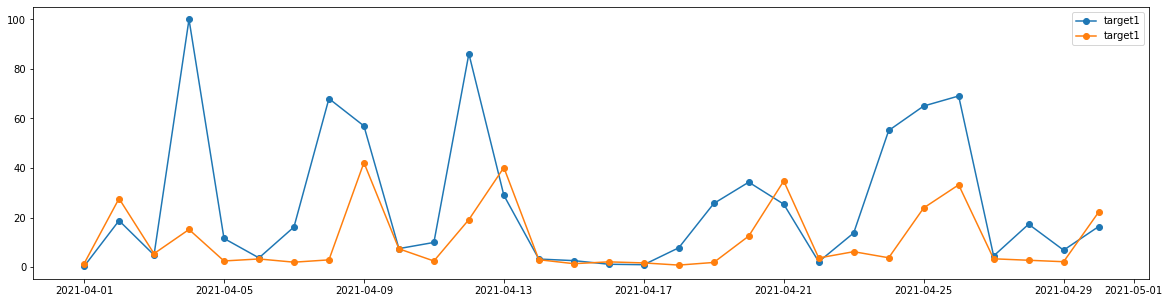

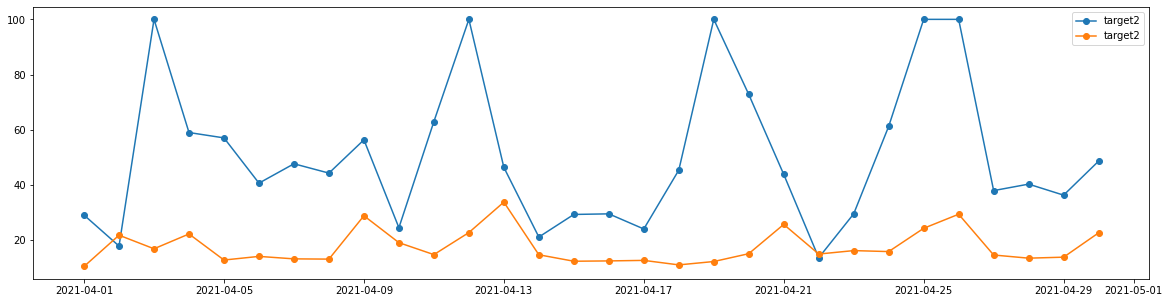

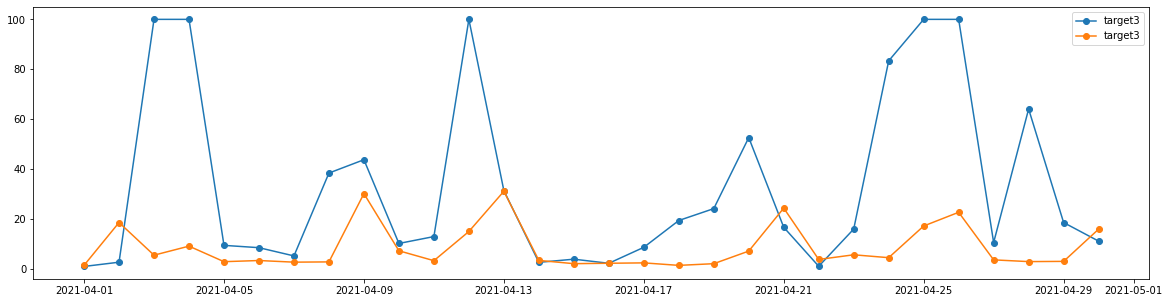

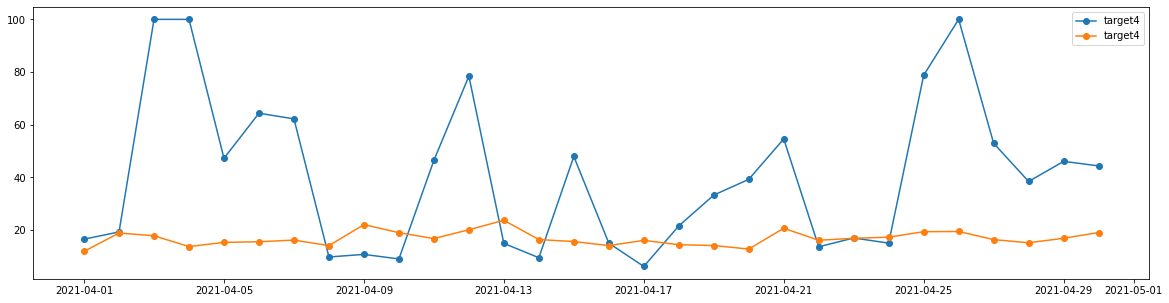

In [184]:
for index in range(1, 5):
    plot_pred(recursive_prediction, playerId=660271, index=index)

In [ ]:
# del train_data, valid_data, target, features #df, raw_train_df, raw_valid_df